In [1]:
cd ~/Dropbox/project_4

/Users/nbeshouri/Documents/Projects/Metis/Project 4


In [2]:
star_wars = [
    'C-3PO', 
    'R2-D2', 
    'Jar Jar Binks', 
    'Luke Skywalker',
    'Jabba the Hutt',
    'Han Solo',
    'Darth Vader',
    'Palpatine',
    'Obi-Wan Kenobi',
    'Yoda',
    'Princess Leia'
]

harry_potter = [
    'Harry Potter (character)',
    'Hermione Granger', 
    'Ron Weasley', 
    'Albus Dumbledore', 
    'Lord Voldemort',
    'Severus Snape',
    'Draco Malfoy'
]

futurama = [
    'Philip J. Fry',
    'Leela (Futurama)',
    'Bender (Futurama)',
    'Professor Farnsworth',
    'Zoidberg',
]


avatar = [
    'Aang',
    'Katara (Avatar: The Last Airbender)',
    'Zuko',
    'Korra',
    'Iroh',
    'Sokka'
]


other = [
    'Jean-Luc Picard', 
    'Eric Cartman',
    'Bart Simpson',
    'Gandalf',
    'Sherlock Holmes',
    'Achilles',
    'Batman',
    'Shawn Spencer',
    'Buffy Summers',
    'Spike (Buffy the Vampire Slayer)',
    'Goku',
    'Edward Elric',
    'Alphonse Elric',
    'Willow Rosenberg',
    'Frodo Baggins',
    'Gollum',
    'Rick Sanchez (Rick and Morty)'
]

coi = star_wars + harry_potter + futurama + avatar + other

In [3]:
from hwtf import utils, data, models, transforms
import numpy as np
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from cycler import cycler
import matplotlib
from sklearn.preprocessing import StandardScaler
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from sklearn.manifold import TSNE
from adjustText import adjust_text
import re

In [12]:
def get_name_to_vec(model):
    name_to_vec = {}
    for name in model.docvecs.doctags.keys():
        name_to_vec[name] = model.docvecs[name]
    return name_to_vec


def get_X_y(model):
    name_to_vec = get_name_to_vec(model)
    y, X =  tuple(map(np.array, zip(*name_to_vec.items())))
    X = StandardScaler().fit_transform(X)
    return X, y


def get_closest_to_center(cluster_centers, points, y, num=5):
    names = []
    for center in cluster_centers:
        diffs = points - center
        distances = np.linalg.norm(diffs, axis=1)
        np.argsort(distances)
        names.append(y[np.argsort(distances)][:num])
    return names


def show_clusters(target_names, all_names, cluster_labels):
    s = pd.Series(cluster_labels, index=all_names)
    s.sort_index(inplace=True)
    return s[s.index.isin(target_names)]


def sample_clusters(all_names, cluster_labels):
    s = pd.Series(cluster_labels, index=all_names)
    for cluster in np.unique(cluster_labels):
        print('Cluster', cluster)
        print(s[s == cluster].sample(20))
        print()

In [13]:
model = utils.load_data('long_run_on_raw.pickle')

In [14]:
name_to_vec = get_name_to_vec(model)
X, y = get_X_y(model)

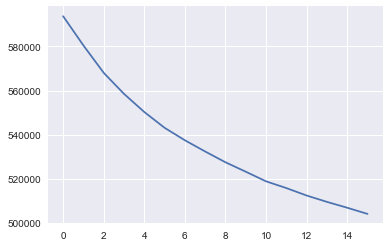

In [16]:
# Plot inertia plot.
inertias = []
for n in range(4, 20):
    temp = cluster.KMeans(n_clusters=n, max_iter=5000)
    temp.fit(X)
    inertias.append(temp.inertia_)
plt.plot(inertias)

In [17]:
# Do the clusting.
kmeans_model = cluster.KMeans(n_clusters=10, max_iter=5000)
cluster_labels = kmeans_model.fit_predict(X)

In [ ]:
# Print the cluster assignments.
show_clusters(coi, y, cluster_labels)

In [ ]:
# Create the labels to give to plotting function.
point_labels = []
short_names = ['Rick', 'Farnsworth', 'Malfoy', 'Bart', 'Jabba', 
               'Snape', 'Voldemort', 'Obi-Wan', 'Jar Jar', 'Luke', 
               'Cartman', 'Buffy', 'Frodo', 'Ron', 'Hermione']
    
for character in coi:
    try:
        i = np.where(y == character)[0][0]
        character = re.sub(r'\(.*\)', '', character).strip()
        for sn in short_names:
            if sn in character:
                character = sn
                break
        point_labels.append((character, i))
    except:
        print(character, "wasn't found in the data set.")

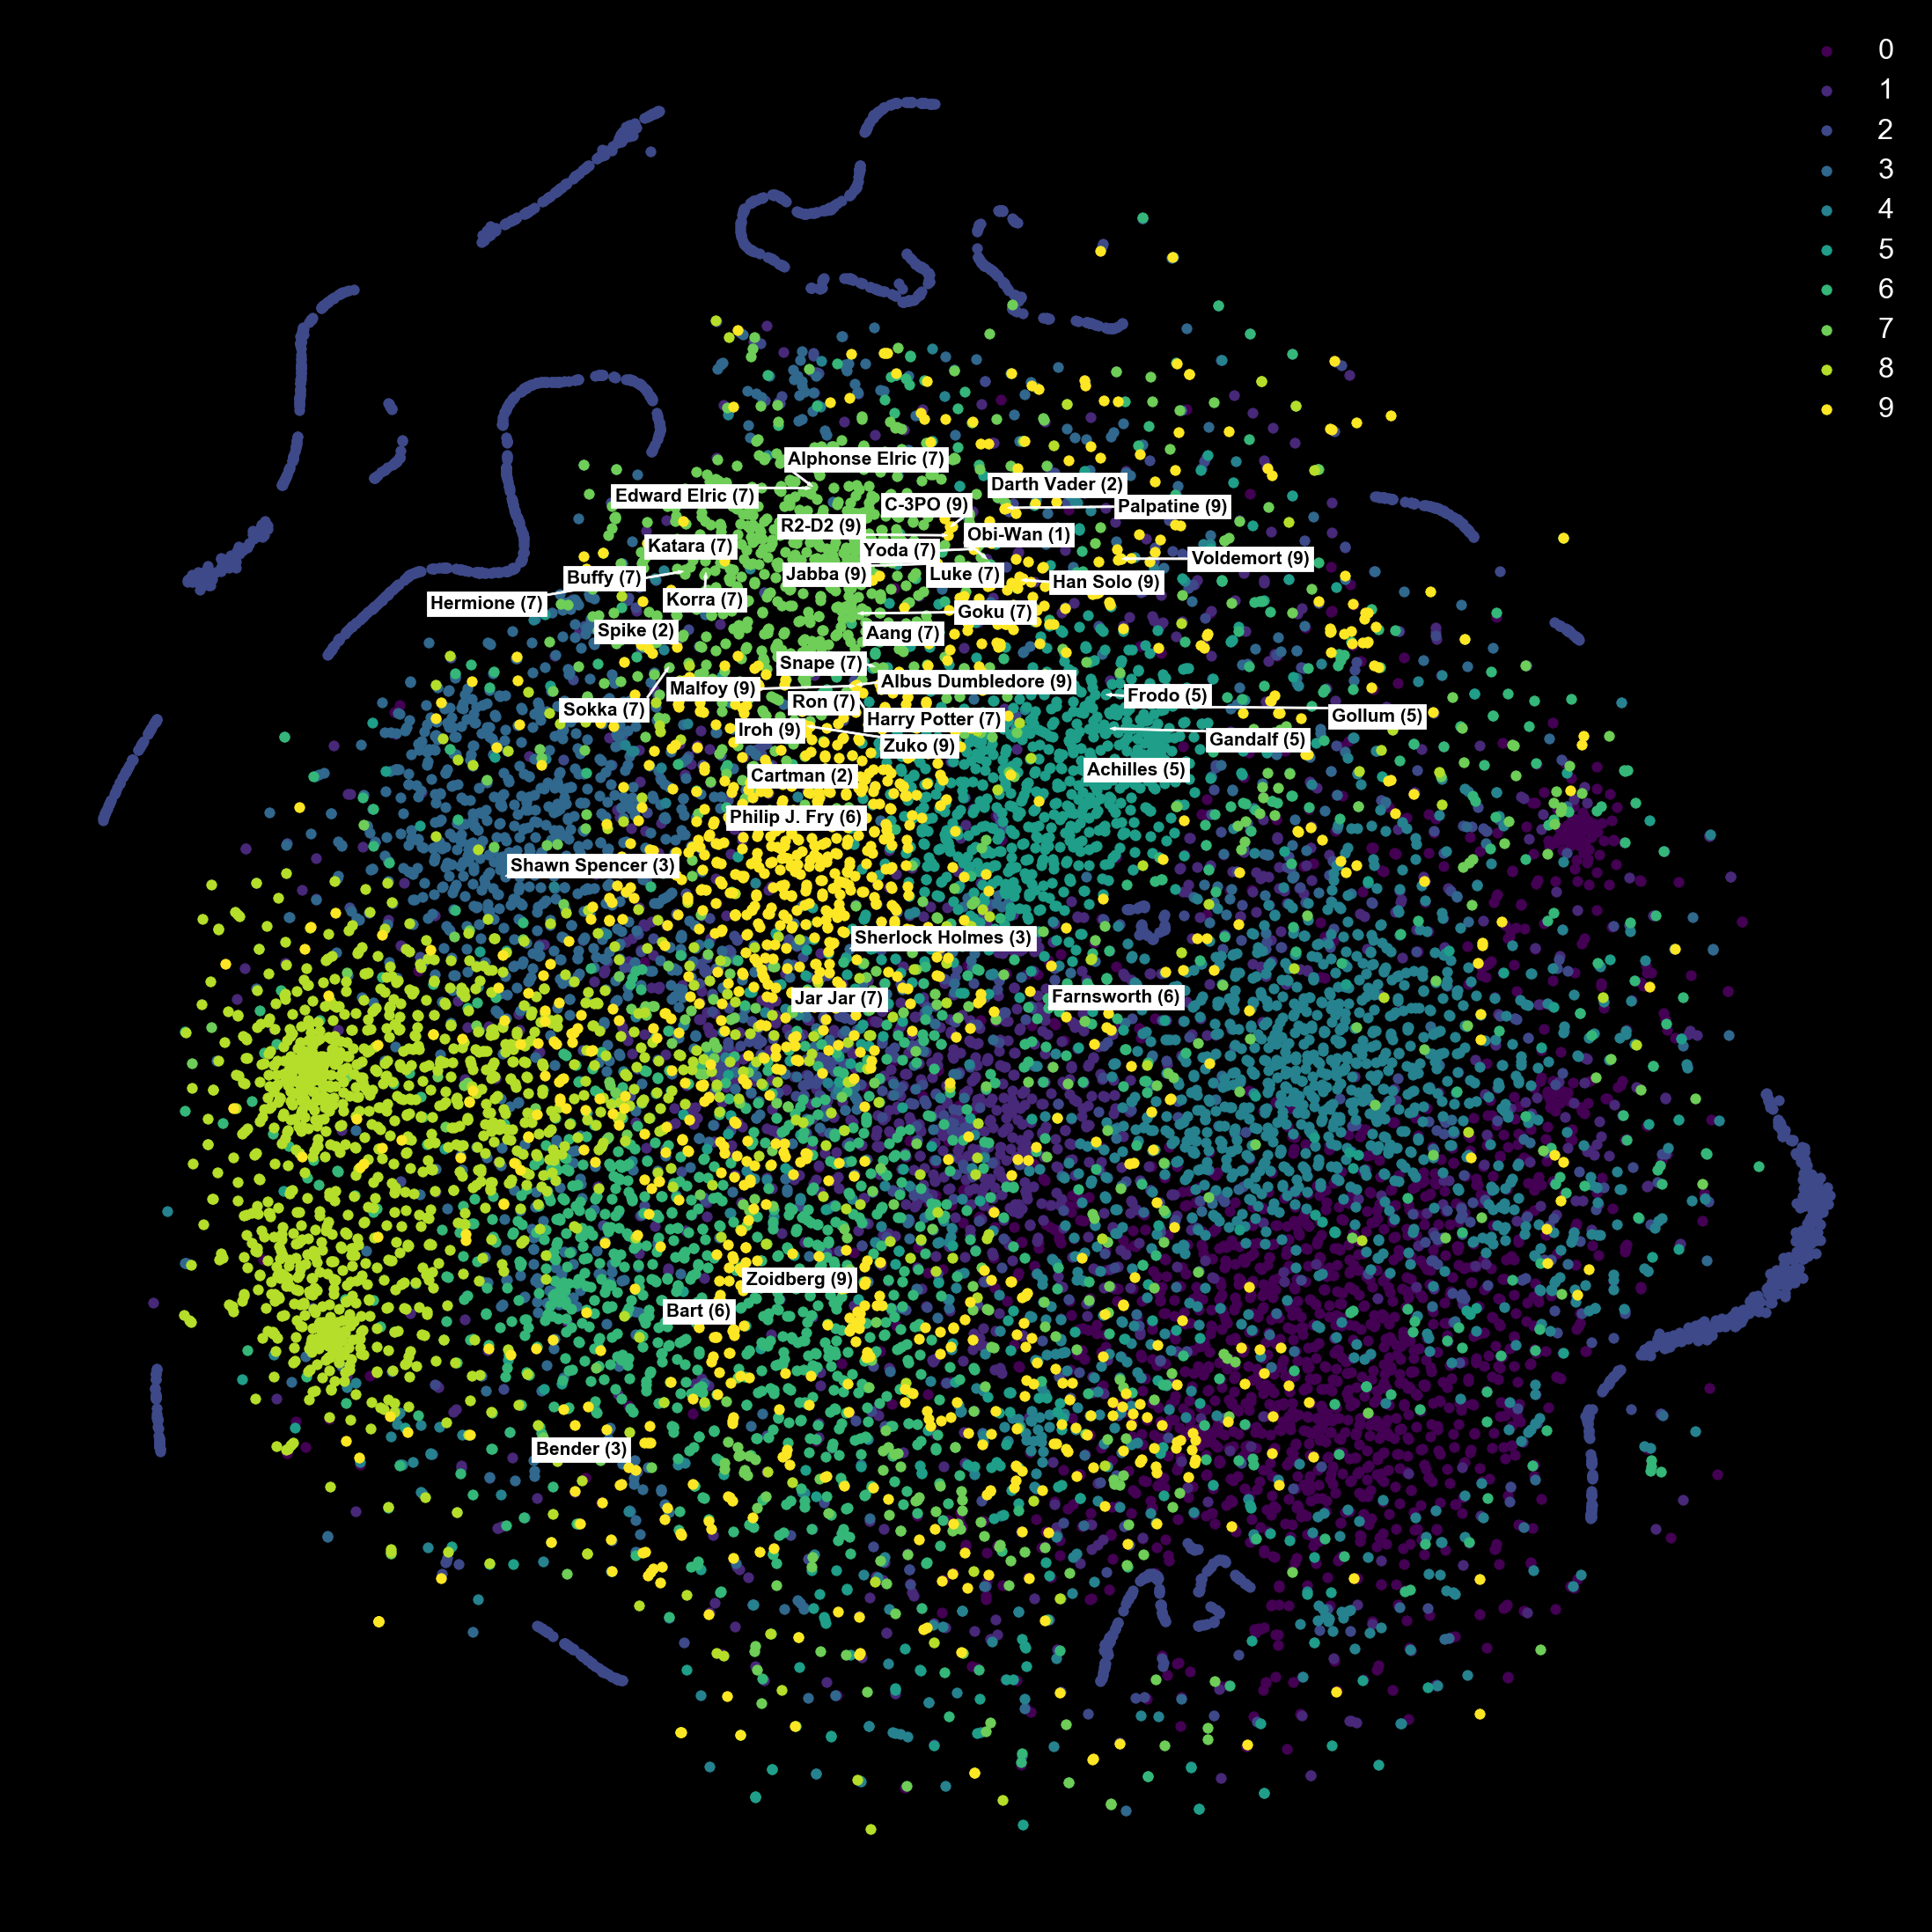

In [34]:
plt.rcParams['figure.dpi'] = 150
sns.set()
plt.style.use("dark_background")
sns.set_context("talk", font_scale=1.2,)

def plot_clustering(points_2d, cluster_labels, point_labels=None):
    tsne = TSNE(n_iter=250)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    cmap = matplotlib.cm.get_cmap('viridis')
    num_clusters = len(np.unique(cluster_labels))
    ax.set_prop_cycle(cycler('color', [cmap(i) for i in np.linspace(0, 1, num_clusters)]))

    for label in np.unique(cluster_labels):
        points = points_2d[cluster_labels == label]
        plt.scatter(points[:, 0], points[:, 1], label=label, s=30)
        
    plt.legend()
    texts = []
    if point_labels is not None:
        
        for label, point_index in point_labels:
            cluster_label = cluster_labels[point_index]
            point = points_2d[point_index]
            box_style = dict(fc='white', pad=2, alpha=1)
            arrow_style =dict(facecolor=('white'), width=1, headwidth=2, headlength=3)
            label += f' ({cluster_label})'
            text = plt.text(
                point[0],
                point[1],
                label, 
                fontsize=10, 
                verticalalignment='bottom', 
                horizontalalignment='center', 
                color='black', 
                weight='bold', 
                bbox=box_style
            )
            texts.append(text)
    adjust_text(texts, arrowprops=arrow_style)
    plt.tight_layout()
    
plot_clustering(points_2d, cluster_labels, point_labels)